The original neighbor implementation does not deal with the negative part of the symmetry matrix.

I need to find a way to get the neighbors within the negative part of the spectrum so that we can perform the message passing mechanism where neighbors from a given point are aggregated via some differentiable function.

The roadmap would be:
 1. Find neihgbors on the negative part of the symmetry spectrum
 2. Make sure that the order of the neighbors is the same as the flattened array corresponding to the negative spectrum, i.e. the index j corresponds to the j-th flattened pixel and the set of neighbors of that same j-th frequency component

In [72]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

from mwReconstruction.dataloader import destripeDataSet
from mwReconstruction.model import *

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd
import torch
from torch.utils.data import Dataset
import os
from glob import glob
import scipy.io as io
# from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import normalized_mutual_information as nmi
from scipy import ndimage
from joblib import Parallel, delayed
from tqdm import tqdm

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
def make_shell(inner_radius, delta_r, tomo_shape):
    """
    Creates a (2D) shell with given inner_radius and delta_r width centered at the middle of the array.
    
    """
    outer_radius = inner_radius + delta_r

    length = min(tomo_shape)
    mask_shape = len(tomo_shape) * [length]
    _shell_mask = np.zeros(mask_shape)

    # only do positive quadrant first
    for y in range(0, outer_radius + 1):
        for x in range(0, outer_radius + 1):

            r = np.linalg.norm([y, x])

            if r >= inner_radius and r < outer_radius:
                yidx = y + length // 2
                xidx = x + length // 2

                _shell_mask[yidx, xidx] = 1

    # first get shell for x>0
    aux = (
        np.rot90(_shell_mask, axes=(0, 1))
        + np.rot90(_shell_mask, 2, axes=(0, 1))
        + np.rot90(_shell_mask, 3, axes=(0, 1))
    )
    aux2 = _shell_mask + aux

    # finally, fill the actual shape of the tomogram with the mask
    shell_mask = np.zeros(tomo_shape)
    shell_mask[
        (tomo_shape[0] - length) // 2 : (tomo_shape[0] + length) // 2,
        (tomo_shape[1] - length) // 2 : (tomo_shape[1] + length) // 2,
    ] = aux2

    return shell_mask

In [74]:
def make_N_neg_matrix(dr, neg_mask, power_mask):
    """
    Returns a pd.DataFrame of shape (N negative components, 65) with the flattened negative frequency components as the index.
    
    The columns correspond to the index value (own neighbor) and 64 randomly choosen, "uncorrupted", neighbors (NaN whenever no neighbor is present) 
    within a ring of radius 3 of each index value. 
    
    All values are given according to the flattened arrays. We assume that we use ZX slices of YZX images (missing wedge in ZX).
    
    - neg_mask: boolean array with 1 wherever the symmatrix equals -1. Shape: (Z,X)
    - power_mask: boolean array indicating low power coefficients. Shape: (Z,X)
    """
    tomo_shape = neg_mask.shape

    neg_neighbors = []

    def get_neighbors(inner_radius):
        # get masks
        ring_mask = make_shell(inner_radius, dr, tomo_shape)
        ring_uncorrupted_mask = (1 - power_mask) * ring_mask
        ring_neg_mask = ring_mask * neg_mask

        # get neighbors
        ring_neg_nghbrs = np.nonzero(ring_neg_mask.flatten())[0]
        ring_uncorrupted_nghbrs = np.nonzero(ring_uncorrupted_mask.flatten())[0]

        k = min(len(ring_uncorrupted_nghbrs), 64)

        # for each negative neighbor, get a random sample of size k from the uncorrupted neighbors. The first neighbor of a point is itself.
        aux = pd.DataFrame(
            [
                np.append(
                    n,
                    np.random.choice(
                        ring_uncorrupted_nghbrs[ring_uncorrupted_nghbrs != n], k
                    ),
                )
                for n in ring_neg_nghbrs
            ],
            index=ring_neg_nghbrs,
        )

        return aux

    neg_neighbors = Parallel(n_jobs=8)(
        delayed(get_neighbors)(inner_radius)
        for inner_radius in np.arange(0, min(tomo_shape) // 2 - dr, dr)
    )
    N_neg = pd.concat(neg_neighbors)

    # make a dummy dataframe with all indices corresponding to negative entries from the symmatrix
    aux = np.nonzero(neg_mask.flatten())[0]
    aux = pd.DataFrame(aux, index=aux)

    # get the final data frame with all negative flattened indices
    all_N_neg = N_neg.join(aux, how="right", rsuffix="_r")
    all_N_neg["0"] = all_N_neg["0_r"]
    all_N_neg.drop("0_r", axis=1, inplace=True)
    all_N_neg.columns = range(65)
    all_N_neg = all_N_neg.sort_index()

    return all_N_neg


# Mapping negative frequency components

We want to find a mapping of the indices from the flattened array versions of the original matrix and the negative component part.

In [75]:
dummy_symmatrix = make_symmatrix(10, 10)
dummy_symmatrix

array([[-1, -1, -1, -1, -1, -1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1, -1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1, -1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1, -1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1, -1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1,  0,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1,  1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1,  1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1,  1,  1,  1,  1,  1],
       [-1, -1, -1, -1, -1,  1,  1,  1,  1,  1]])

In [76]:
dummy_symmask = torch.from_numpy(dummy_symmatrix).float()

_, global_to_neg_mapping = torch.sort(
            torch.cat(
                [
                    torch.where(dummy_symmask.reshape(-1) == index)[0]
                    for index in [-1, 0, 1]
                ]
            )
        )

In [115]:
global_to_neg_mapping = torch.where(dummy_symmask.flatten()==-1)[0]

_mapping = zip(global_to_neg_mapping.numpy(), range(len(global_to_neg_mapping)))
global_to_neg_mapping = dict(_mapping)

In [116]:
global_to_neg_mapping

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 10: 6,
 11: 7,
 12: 8,
 13: 9,
 14: 10,
 15: 11,
 20: 12,
 21: 13,
 22: 14,
 23: 15,
 24: 16,
 25: 17,
 30: 18,
 31: 19,
 32: 20,
 33: 21,
 34: 22,
 35: 23,
 40: 24,
 41: 25,
 42: 26,
 43: 27,
 44: 28,
 45: 29,
 50: 30,
 51: 31,
 52: 32,
 53: 33,
 54: 34,
 60: 35,
 61: 36,
 62: 37,
 63: 38,
 64: 39,
 70: 40,
 71: 41,
 72: 42,
 73: 43,
 74: 44,
 80: 45,
 81: 46,
 82: 47,
 83: 48,
 84: 49,
 90: 50,
 91: 51,
 92: 52,
 93: 53,
 94: 54}

In [85]:
dummy_powerMask = np.zeros_like(dummy_symmatrix)

In [122]:
np.random.choice(ring_uncorrupted_nghbrs[ring_uncorrupted_nghbrs!=n], 5)

array([40, 15, 61, 61, 30])

In [186]:
tomo_shape = dummy_symmask.shape

neg_mask = (dummy_symmatrix==-1).astype(int)

neg_neighbors = []

dr = 2

inner_radius = 3
# get masks
ring_mask = make_shell(inner_radius, dr, tomo_shape)
ring_neg_mask = ring_mask*neg_mask
ring_uncorrupted_mask = (1-dummy_powerMask)*ring_neg_mask


# get neighbors
ring_neg_nghbrs = np.nonzero(ring_neg_mask.flatten())[0] 
ring_uncorrupted_nghbrs = np.nonzero(ring_uncorrupted_mask.flatten())[0]

# ring_neg_nghbrs = global_to_neg_mapping[ring_neg_nghbrs].numpy()
# ring_uncorrupted_nghbrs = global_to_neg_mapping[ring_uncorrupted_nghbrs].numpy()

k = min(len(ring_uncorrupted_nghbrs), 5)

def retrieve_mapped_random_neighbors(n, k):
    from operator import itemgetter
    
    aux = np.random.choice(ring_uncorrupted_nghbrs[ring_uncorrupted_nghbrs!=n], k)
    return itemgetter(*aux)(global_to_neg_mapping)


# for each negative neighbor, get a random sample of size k from the uncorrupted neighbors. The first neighbor of a point is itself.
aux = pd.DataFrame([np.append(global_to_neg_mapping[n],
                              retrieve_mapped_random_neighbors(n, k))
                    for n in ring_neg_nghbrs], index=ring_neg_nghbrs)

neg_neighbors.append(aux)
    
    
N_neg = pd.concat(neg_neighbors)

# make a dummy dataframe with all indices corresponding to negative entries from the symmatrix
aux = len(np.nonzero(neg_mask.flatten())[0])
aux = pd.DataFrame(range(aux), index=range(aux))

# get the final data frame with all negative flattened indices
all_N_neg = N_neg.join(aux, on=0, how='right', rsuffix='_r')
all_N_neg['0'] = all_N_neg['0_r']
all_N_neg.index = all_N_neg['key_0'].values

all_N_neg.drop(['0_r', 'key_0'], axis=1, inplace=True)

# all_N_neg.columns = range(6)
all_N_neg = all_N_neg.sort_index()

In [187]:
all_N_neg

,0,1,2,3,4,5
0,0,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN
2,2,54.0,54.0,53.0,7.0,30.0
3,3,9.0,30.0,36.0,9.0,36.0
4,4,7.0,12.0,35.0,7.0,3.0
5,5,25.0,53.0,19.0,25.0,54.0
6,6,NaN,NaN,NaN,NaN,NaN
7,7,47.0,10.0,36.0,30.0,30.0
8,8,9.0,52.0,41.0,2.0,18.0
9,9,18.0,31.0,48.0,8.0,13.0


In [195]:
dummy_x_neg = torch.rand(len(global_to_neg_mapping))
dummy_x_neg = torch.cat((dummy_x_neg, torch.tensor([0])))
dummy_x_neg

tensor([0.7823, 0.7252, 0.8014, 0.8677, 0.2818, 0.3610, 0.2056, 0.1001, 0.0559,
        0.7904, 0.3317, 0.6895, 0.6847, 0.1278, 0.7532, 0.4781, 0.2896, 0.2107,
        0.5697, 0.6209, 0.6235, 0.5496, 0.4107, 0.5927, 0.1084, 0.2096, 0.7000,
        0.0116, 0.7668, 0.8750, 0.7278, 0.4157, 0.3888, 0.4689, 0.1951, 0.2051,
        0.6333, 0.4495, 0.0075, 0.0599, 0.6933, 0.8133, 0.6100, 0.5247, 0.7663,
        0.3224, 0.8888, 0.6881, 0.0024, 0.1334, 0.5197, 0.5030, 0.6172, 0.3170,
        0.4091, 0.0000])

In [197]:
message_tensor = torch.tensor(all_N_neg.fillna(-1).to_numpy()).long()
message_tensor = dummy_x_neg[message_tensor]

message_tensor.sum(1).shape

torch.Size([55])

In [8]:
cet_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_allTomos_deconv/tomo10.mrc')    

my_dataset = destripeDataSet(path = cet_path, logTransform=False)
len(my_dataset)

928

In [9]:
input_2d_slice = my_dataset.x_data[len(my_dataset)//2][0].squeeze()
input_2d_slice.shape

fourier_2d_slice = fft.fftshift(fft.fft2(input_2d_slice))

m, n = fourier_2d_slice.size()

In [10]:
symmatrix = make_symmatrix(n, m)  # this is an np.array
symmask = torch.from_numpy(symmatrix).float()

symmask.shape, fourier_2d_slice.shape

(torch.Size([464, 928]), torch.Size([464, 928]))

In [11]:
outlier_mask = my_dataset.x_data[len(my_dataset)//2][1].squeeze()
weight_matrix = my_dataset.x_data[len(my_dataset)//2][2].squeeze()

# Neighbor mask

In [65]:
tomo_shape = input_2d_slice.shape

# corrupted indices are labelled depending on their power
power_mask = outlier_mask.numpy().copy() # yields 1 for corrupted coefficients

symmatrix = make_symmatrix(tomo_shape[1], tomo_shape[0])
symmask = torch.from_numpy(symmatrix).float()

neg_mask = (symmatrix==-1).astype(int)

_, global_to_neg_mapping = torch.sort(
            torch.cat(
                [
                    torch.where(symmask.reshape(-1) == index)[0]
                    for index in [-1, 0, 1]
                ]
            )
        )

neg_neighbors = []

dr = 3

for inner_radius in tqdm(np.arange(0, min(tomo_shape)//2 - dr, dr)):
    
    inner_radius = 50
    # get masks
    ring_mask = make_shell(inner_radius, dr, tomo_shape)
    ring_uncorrupted_mask = (1-power_mask)*ring_mask
    ring_neg_mask = ring_mask*neg_mask
    
    # get neighbors
    ring_neg_nghbrs = np.nonzero(ring_neg_mask.flatten())[0] 
    ring_uncorrupted_nghbrs = np.nonzero(ring_uncorrupted_mask.flatten())[0]
    
    # ring_neg_nghbrs = global_to_neg_mapping[ring_neg_nghbrs].numpy()
    # ring_uncorrupted_nghbrs = global_to_neg_mapping[ring_uncorrupted_nghbrs].numpy()
    
    k = min(len(ring_uncorrupted_nghbrs), 64)
    
    # for each negative neighbor, get a random sample of size k from the uncorrupted neighbors. The first neighbor of a point is itself.
    aux = pd.DataFrame([np.append(global_to_neg_mapping[n], 
                                  global_to_neg_mapping[np.random.choice(ring_uncorrupted_nghbrs[ring_uncorrupted_nghbrs!=n], k)]
                                 )
                        for n in ring_neg_nghbrs], index=ring_neg_nghbrs)
    
    neg_neighbors.append(aux)
    
    
N_neg = pd.concat(neg_neighbors)

# make a dummy dataframe with all indices corresponding to negative entries from the symmatrix
aux = np.nonzero(neg_mask.flatten())[0]
aux = pd.DataFrame(aux, index=aux)

# get the final data frame with all negative flattened indices
all_N_neg = N_neg.join(aux, how='right', rsuffix='_r')
# all_N_neg['0'] = all_N_neg['0_r']
# all_N_neg.drop('0_r', axis=1, inplace=True)
# all_N_neg.columns = range(65)
# all_N_neg = all_N_neg.sort_index()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:04<00:00, 17.36it/s]


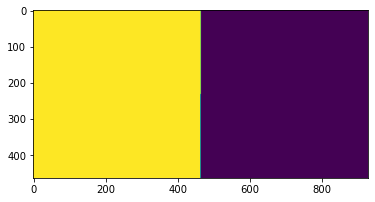

In [71]:
plt.imshow(neg_mask)

In [69]:
(all_N_neg.index!=all_N_neg['0_r'])

array([False, False, False, ..., False, False, False])

In [38]:
a = np.nonzero(ring_neg_mask.flatten())[0]

In [40]:
mask_ind[a]

tensor([ 83688,  83689,  83690,  83691,  83692,  83693,  83694,  83695,  83696,
         83697,  83698,  83699,  84149,  84150,  84151,  84152,  84153,  84154,
         84155,  84156,  84157,  84158,  84159,  84160,  84161,  84162,  84163,
         84164,  84611,  84612,  84613,  84614,  84615,  84616,  84617,  84618,
         84619,  84620,  84621,  84622,  84623,  84624,  84625,  84626,  84627,
         84628,  84629,  85073,  85074,  85075,  85076,  85077,  85078,  85079,
         85080,  85081,  85082,  85083,  85536,  85537,  85538,  85539,  85540,
         85541,  85542,  85543,  85544,  85999,  86000,  86001,  86002,  86003,
         86004,  86005,  86462,  86463,  86464,  86465,  86466,  86467,  86468,
         86926,  86927,  86928,  86929,  86930,  86931,  87389,  87390,  87391,
         87392,  87393,  87394,  87853,  87854,  87855,  87856,  87857,  88316,
         88317,  88318,  88319,  88320,  88780,  88781,  88782,  88783,  88784,
         89244,  89245,  89246,  89247, 

In [30]:
torch.sort(symmask.flatten())

torch.return_types.sort(
values=tensor([-1., -1., -1.,  ...,  1.,  1.,  1.]),
indices=tensor([238904, 238912, 238911,  ...,  88690,  88689,  88688]))

In [26]:
ring_mask[symmatrix==-1]

array([0., 0., 0., ..., 0., 0., 0.])

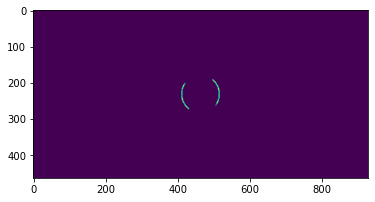

In [31]:
plt.imshow(ring_uncorrupted_mask)

In [18]:
aux

,0
0,0
1,1
2,2
3,3
4,4
...,...
430123,430123
430124,430124
430125,430125
430126,430126
